In [1]:
%%capture
!pip3 install numpy pandas matplotlib scikit-learn keras tensorflow seaborn scikeras

In [2]:
import time
import keras
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
from scipy.stats import trim_mean
from scipy.stats.mstats import winsorize
from enum import Enum
from sklearn.feature_selection import f_regression
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.initializers import glorot_uniform
from keras.optimizers import Adagrad
from keras.callbacks import LearningRateScheduler
from keras.initializers import he_normal
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping
from scipy import stats

2024-01-08 21:05:22.519958: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Ensuring that every time that this Jupyter notebook is executed, the exact same results are obtained.

In [3]:
random.seed(53)
np.random.seed(53)

# 1. Data Extraction

To begin, obtain the dataset by visiting the [Kaggle Challenge](https://www.kaggle.com/competitions/higgs-boson-detection/overview) or the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/280/higgs) and download the CSV file named `HIGGS.csv`.

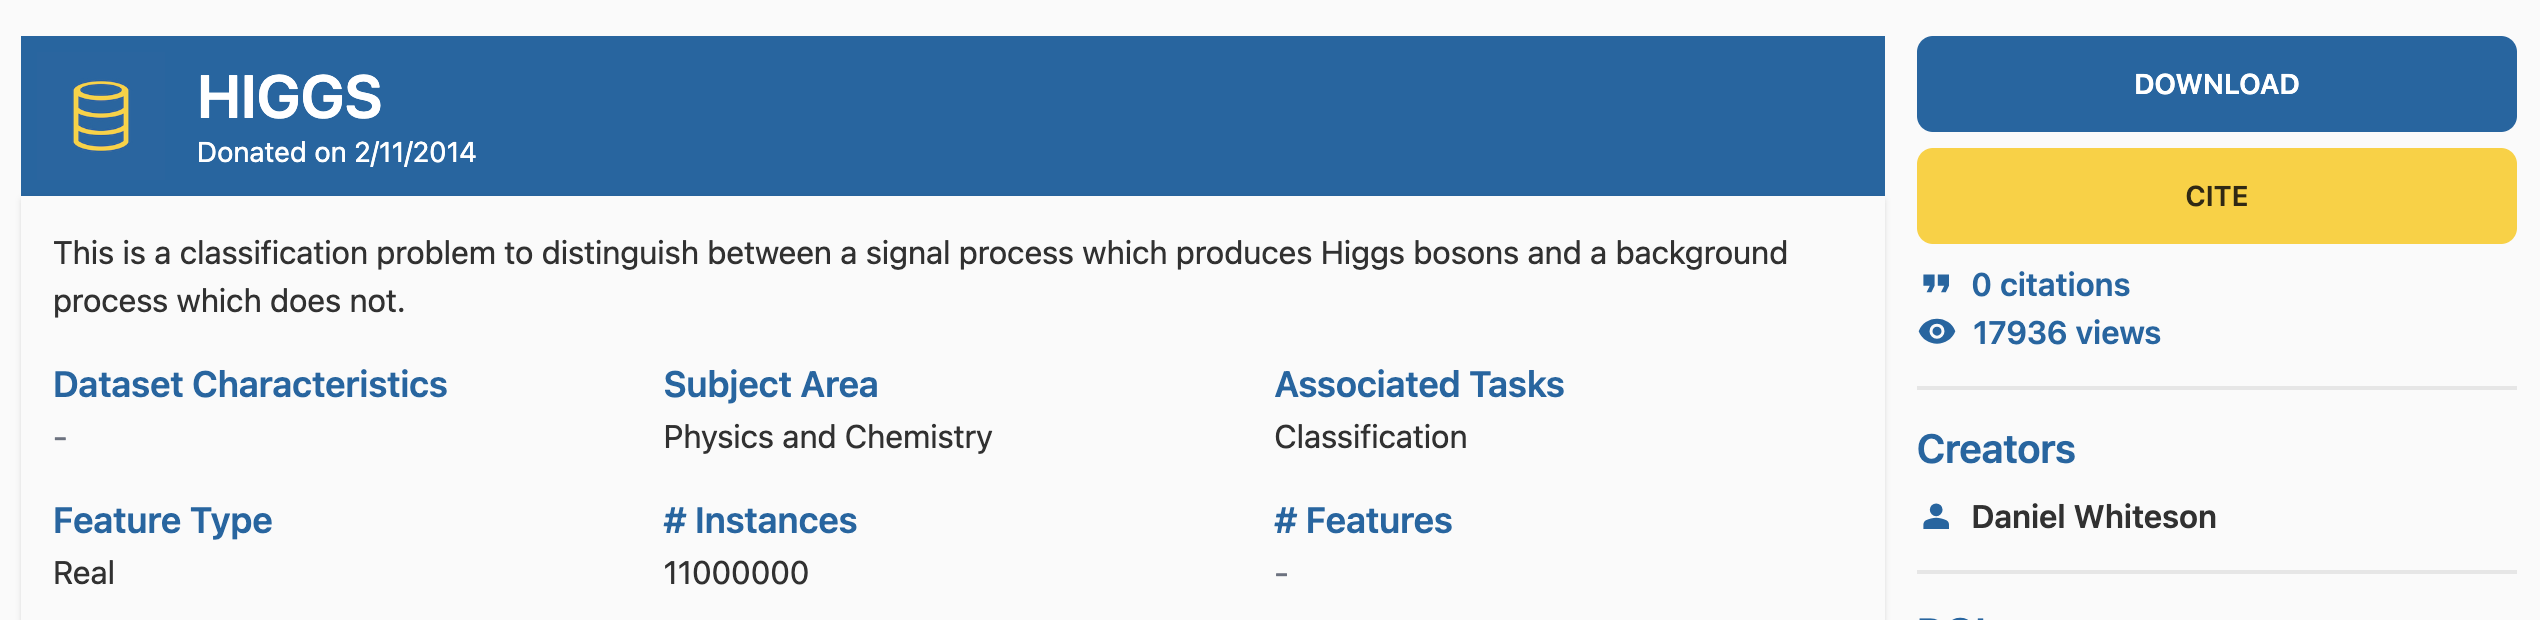

Define the field names utilizing a Python Enum subclass for better reference and code clarity:

In [4]:
class Feature(Enum):
    TARGET = 'signal'

    # Low-energy attributes.
    LEPTON_PT = 'lepton pT'
    LEPTON_ETA = 'lepton eta'
    LEPTON_PHI = 'lepton phi'
    MISSING_ENERGY_MAG = 'missing energy magnitude'
    MISSING_ENERGY_PHI = 'missing energy phi'
    JET_1_PT = 'jet 1 pt'
    JET_1_ETA = 'jet 1 eta'
    JET_1_PHI = 'jet 1 phi'
    JET_1_B_TAG = 'jet 1 b-tag'
    JET_2_PT = 'jet 2 pt'
    JET_2_ETA = 'jet 2 eta'
    JET_2_PHI = 'jet 2 phi'
    JET_2_B_TAG = 'jet 2 b-tag'
    JET_3_PT = 'jet 3 pt'
    JET_3_ETA = 'jet 3 eta'
    JET_3_PHI = 'jet 3 phi'
    JET_3_B_TAG = 'jet 3 b-tag'
    JET_4_PT = 'jet 4 pt'
    JET_4_ETA = 'jet 4 eta'
    JET_4_PHI = 'jet 4 phi'
    JET_4_B_TAG = 'jet 4 b-tag'

    # High-energy attributes.
    M_JJ = 'm_jj'
    M_JJJ = 'm_jjj'
    M_LV = 'm_lv'
    M_JLV = 'm_jlv'
    M_BB = 'm_bb'
    M_WBB = 'm_wbb'
    M_WWBB = 'm_wwbb'


Use [Python's Pandas](https://pandas.pydata.org/) to load the dataset. It is needed to manually specify the column names since the CSV file does not contain any headers.

In [5]:
raw_df = pd.read_csv('HIGGS.csv', header=None, names=[field.value for field in Feature])

To understand the size of the dataset, print the number of rows and columns.

In [6]:
raw_df.shape

(11000000, 29)

# 2. Data Cleaning

### 2.1 Data Type Conversion

Evaluate each attribute's data type to determine the necessity for type conversion:

In [7]:
raw_df.dtypes

signal                      float64
lepton pT                   float64
lepton eta                  float64
lepton phi                  float64
missing energy magnitude    float64
missing energy phi          float64
jet 1 pt                    float64
jet 1 eta                   float64
jet 1 phi                   float64
jet 1 b-tag                 float64
jet 2 pt                    float64
jet 2 eta                   float64
jet 2 phi                   float64
jet 2 b-tag                 float64
jet 3 pt                    float64
jet 3 eta                   float64
jet 3 phi                   float64
jet 3 b-tag                 float64
jet 4 pt                    float64
jet 4 eta                   float64
jet 4 phi                   float64
jet 4 b-tag                 float64
m_jj                        float64
m_jjj                       float64
m_lv                        float64
m_jlv                       float64
m_bb                        float64
m_wbb                       

Type conversion is not required as all attributes are of type float64.

### 2.2 Categorical Type Encoding

Encoding of categorical features is not necessary since all attributes are numerical.

### 2.3 Removing Duplicate Rows

Use Pandas' built-in functionality to remove duplicated rows.

In [8]:
deduped_df = raw_df.drop_duplicates()

Confirm there are no more duplicates by examining the dataset's dimensions again.

In [9]:
deduped_df.shape

(10721302, 29)

### 2.4 Handling Missing Values

Count null values to determine if missing data treatment is necessary.

In [10]:
deduped_df.isnull().sum()

signal                      0
lepton pT                   0
lepton eta                  0
lepton phi                  0
missing energy magnitude    0
missing energy phi          0
jet 1 pt                    0
jet 1 eta                   0
jet 1 phi                   0
jet 1 b-tag                 0
jet 2 pt                    0
jet 2 eta                   0
jet 2 phi                   0
jet 2 b-tag                 0
jet 3 pt                    0
jet 3 eta                   0
jet 3 phi                   0
jet 3 b-tag                 0
jet 4 pt                    0
jet 4 eta                   0
jet 4 phi                   0
jet 4 b-tag                 0
m_jj                        0
m_jjj                       0
m_lv                        0
m_jlv                       0
m_bb                        0
m_wbb                       0
m_wwbb                      0
dtype: int64

No further treatment is needed, since there are no missing values.

### 2.5 Outlier Detection

Count records that fall outside multiple standard deviations from the mean to identify potential outliers.

In [11]:
SIGMAS = 8  # The amount of standard deviations from the mean outside of which a datapoint is considered an outlier.

outliers = deduped_df.abs() > (deduped_df.mean() + SIGMAS * deduped_df.std())
outliers.sum()

signal                          0
lepton pT                    1784
lepton eta                      0
lepton phi                      0
missing energy magnitude     1595
missing energy phi              0
jet 1 pt                     1333
jet 1 eta                       0
jet 1 phi                       0
jet 1 b-tag                     0
jet 2 pt                     2409
jet 2 eta                       0
jet 2 phi                       0
jet 2 b-tag                     0
jet 3 pt                     2635
jet 3 eta                       0
jet 3 phi                       0
jet 3 b-tag                     0
jet 4 pt                     1915
jet 4 eta                       0
jet 4 phi                       0
jet 4 b-tag                     0
m_jj                        23449
m_jjj                       17960
m_lv                        15054
m_jlv                        8086
m_bb                         6250
m_wbb                        6800
m_wwbb                       5589
dtype: int64

For features with more than 10.000 datapoints outside of the 8 standard deviations, maybe it is better to use another strategy to detect outliers. As a result, the following cell calculates the very small percentile of data that lies at the extremes.

In [12]:
PERCENTILE = 0.9999 # Percentile outside of which a, absolute datapoint is considered an outlier.

outliers = deduped_df.abs() > deduped_df.abs().quantile(PERCENTILE)
outliers.sum()

signal                         0
lepton pT                   1073
lepton eta                  1058
lepton phi                     0
missing energy magnitude    1073
missing energy phi          1063
jet 1 pt                    1073
jet 1 eta                   1050
jet 1 phi                      0
jet 1 b-tag                    0
jet 2 pt                    1073
jet 2 eta                   1021
jet 2 phi                      0
jet 2 b-tag                    0
jet 3 pt                    1073
jet 3 eta                    991
jet 3 phi                      0
jet 3 b-tag                    0
jet 4 pt                    1073
jet 4 eta                    987
jet 4 phi                      0
jet 4 b-tag                    0
m_jj                        1073
m_jjj                       1073
m_lv                        1073
m_jlv                       1073
m_bb                        1073
m_wbb                       1073
m_wwbb                      1073
dtype: int64

Remove outliers from the dataset:

In [13]:
regular_df = deduped_df[~outliers.any(axis=1)]
regular_df.shape

(10704979, 29)

Ensuring that even after the deletion of outliers, there are enough positive and negative signal data points.

In [14]:
assert len(regular_df['signal'].unique()) == 2

### 2.6 Dimensionality Reduction

The R-squared score, is a statistical measure that represents the proportion of the variance for a dependent variable that is explained by one or more independent variables in a regression model.

An R-squared score close to 1 suggests that a large proportion of the variance in the dependent variable has been accounted for by the regression model. This implies that the independent variables in the model are good predictors of the dependent variable.

In the dataset with 28 features, the permutations for feature combinations are 28!. Therefore, we face the [combinatorial explosion problem](https://en.wikipedia.org/wiki/Combinatorial_explosion). To avoid that, we evaluate the R-squared score of each individual feature. We then select the feature with the highest R-square score and proceed to examine its interaction with the remaining 27 features through an F-Test. We continue doing that for the rest of the feature combinations, adding one feature at a time and selecting the combination that returns the highest R-square score at each step. This process continues until we achieve a sufficient explanatory power within the model.

However, performance issues have taken me to do the exact opposite: Starting by assuming that all features are good predictors and removing the one that yields the lowest variation in R-score when compared with the best score so far.

Even though the relationship between the features and the signal might not be linear, the strategy of the F-Test is useful to discard those features whose variance does not explain the target signal properly.

In [15]:
PREDICTORS_TO_REMOVE = 3 # Amount of features to be discarded from the dataset due to to low R-squared score.
TOTAL_COMBINATIONS = len(Feature) * PREDICTORS_TO_REMOVE # Estimated amount of iterations.
SAMPLE_FRACTION = 0.05 # Percentage of the data that will be used for evaluating the R-squared score.

start_time = time.time()
iteration = 0

best_predictors = [feature.value for feature in Feature if feature != Feature.TARGET]

for _ in range(PREDICTORS_TO_REMOVE):
    scores = []
    for predictor in best_predictors:

        # Just printing a message every few iterations.
        if not iteration % int(TOTAL_COMBINATIONS / 20):
            elapsed = time.time() - start_time
            eta = (TOTAL_COMBINATIONS - iteration - 1) * elapsed / (iteration + 1)
            print(f"{time.ctime()} #{iteration + 1}/{TOTAL_COMBINATIONS}. Elapsed: {elapsed:.2f}s. ETA: {eta:.2f}s")
        iteration += 1

        # Taking a random sample of the dataset without one single feature,
        # which is used to validate how well the resulting sub-dataset predicts the signal.
        combination = [feature for feature in best_predictors if feature != predictor]
        x = regular_df[combination].sample(frac=SAMPLE_FRACTION)
        y = regular_df[Feature.TARGET.value].loc[x.index]
        
        # Calculating the R-squared score.
        model = LinearRegression().fit(x, y)
        score = r2_score(y, model.predict(x))
        scores.append({'Feature': predictor, 'R-squared score': score})

    # Remove the feature with the least significance.
    print(pd.DataFrame(scores).set_index('Feature'))
    worst_predictor =  min(scores, key=lambda x: x['R-squared score'])['Feature']
    print(f'Worst predictor is "{worst_predictor}"')
    best_predictors.remove(worst_predictor)

Mon Jan  8 21:07:42 2024 #1/87. Elapsed: 0.00s. ETA: 0.04s
Mon Jan  8 21:07:52 2024 #5/87. Elapsed: 10.34s. ETA: 169.56s
Mon Jan  8 21:08:02 2024 #9/87. Elapsed: 19.74s. ETA: 171.05s
Mon Jan  8 21:08:12 2024 #13/87. Elapsed: 29.92s. ETA: 170.34s
Mon Jan  8 21:08:21 2024 #17/87. Elapsed: 39.13s. ETA: 161.13s
Mon Jan  8 21:08:30 2024 #21/87. Elapsed: 48.31s. ETA: 151.84s
Mon Jan  8 21:08:39 2024 #25/87. Elapsed: 57.58s. ETA: 142.79s
                          R-squared score
Feature                                  
lepton pT                        0.093147
lepton eta                       0.097098
lepton phi                       0.097642
missing energy magnitude         0.088088
missing energy phi               0.098752
jet 1 pt                         0.083687
jet 1 eta                        0.097592
jet 1 phi                        0.097753
jet 1 b-tag                      0.098031
jet 2 pt                         0.096489
jet 2 eta                        0.097799
jet 2 phi          

Drop the features that do not participate in the best predictors, according to the R-squared score.

In [16]:
reduced_df = regular_df[[Feature.TARGET.value, *best_predictors]]
reduced_df.dtypes

signal                      float64
lepton pT                   float64
lepton eta                  float64
lepton phi                  float64
missing energy magnitude    float64
missing energy phi          float64
jet 1 pt                    float64
jet 1 eta                   float64
jet 1 phi                   float64
jet 1 b-tag                 float64
jet 2 pt                    float64
jet 2 eta                   float64
jet 2 phi                   float64
jet 2 b-tag                 float64
jet 3 pt                    float64
jet 3 eta                   float64
jet 3 phi                   float64
jet 3 b-tag                 float64
jet 4 pt                    float64
jet 4 eta                   float64
jet 4 phi                   float64
jet 4 b-tag                 float64
m_jj                        float64
m_jjj                       float64
m_lv                        float64
m_jlv                       float64
dtype: object

### 2.7 Feature Scaling

Calculate minimum, maximum, average and standard deviation of each feature. The `stats_df` is later needed in order to normalize both the training data and the online predictions.

In [17]:
stats_df = pd.DataFrame({
    'Mean': reduced_df.mean(),
    'Std': reduced_df.std(),
    'Min': reduced_df.min(),
    'Max': reduced_df.max()
})
stats_df

,Mean,Std,Min,Max
signal,0.543922,0.498067,0.000000,1.000000
lepton pT,0.989767,0.559807,0.274697,5.851532
lepton eta,-0.000035,1.008226,-2.428158,2.428050
lepton phi,-0.000010,1.006376,-1.742508,1.743236
missing energy magnitude,0.995501,0.593610,0.000237,6.109808
missing energy phi,0.000202,1.006232,-1.743616,1.743257
jet 1 pt,0.989880,0.469982,0.137502,4.926362
jet 1 eta,0.000014,1.008626,-2.961803,2.961752
jet 1 phi,0.000084,1.005877,-1.741237,1.741454
jet 1 b-tag,0.999737,1.027822,0.000000,2.173076


[Normalize](https://en.wikipedia.org/wiki/Normalization_(statistics)) features using `stats_df`. That way, all features have a mean of `0` and a standard deviation of `1`.

In [18]:
normalized_df = (reduced_df - stats_df['Mean']) / stats_df['Std']
normalized_df[Feature.TARGET.value] = reduced_df[Feature.TARGET.value]

In [19]:
normalized_stats_df = pd.DataFrame({
    'Mean': normalized_df.mean(),
    'Std': normalized_df.std(),
    'Min': normalized_df.min(),
    'Max': normalized_df.max()
})
normalized_stats_df

,Mean,Std,Min,Max
signal,5.439223e-01,0.498067,0.000000,1.000000
lepton pT,-2.016273e-17,1.000000,-1.277351,8.684719
lepton eta,9.819514e-18,1.000000,-2.408313,2.408275
lepton phi,-1.376352e-17,1.000000,-1.731459,1.732201
missing energy magnitude,1.347212e-15,1.000000,-1.676629,8.615599
missing energy phi,9.337632e-18,1.000000,-1.733018,1.732259
jet 1 pt,-1.761214e-16,1.000000,-1.813639,8.375816
jet 1 eta,1.537244e-17,1.000000,-2.936487,2.936408
jet 1 phi,-3.459995e-17,1.000000,-1.731147,1.731195
jet 1 b-tag,-1.583309e-17,1.000000,-0.972675,1.141579


### 2.8 Data Augmentation

Since approximately 50% of the records belong to the positive (and the negative) class, it is not necessary to artificially augment the dataset with noisy records that might affect the results in unreliable ways.

In [20]:
counts = normalized_df['signal'].value_counts()
counts

signal
1.0    5822677
0.0    4882302
Name: count, dtype: int64

Running a simple `t-statistic` test, to verify the probability of seeing these 2 values if the mean if `0.5`, which indicates that is was taken from a normal (random) distribution.

In [21]:
null_hypothesis_mean = 0.5
t_statistic, p_value = stats.ttest_1samp(np.array(list(counts)), null_hypothesis_mean)
print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 11.383733085205371
P-value: 0.05578045243352286


# 3. Exploratory Analysis

### 3.1 Summary Statistics

Compute basic statistics so that you can grasp an idea of what the data looks like.

In [22]:
summary = normalized_df.drop(Feature.TARGET.value, axis=1).agg(['max', 'min']).T
summary['10%'] = normalized_df.quantile(0.10)
summary['20%'] = normalized_df.quantile(0.20)
summary['30%'] = normalized_df.quantile(0.30)
summary['40%'] = normalized_df.quantile(0.40)
summary['50%'] = normalized_df.quantile(0.50)
summary['60%'] = normalized_df.quantile(0.60)
summary['70%'] = normalized_df.quantile(0.70)
summary['80%'] = normalized_df.quantile(0.80)
summary['90%'] = normalized_df.quantile(0.90)
summary

,max,min,10%,20%,30%,40%,50%,60%,70%,80%,90%
lepton pT,8.684719,-1.277351,-0.997839,-0.802671,-0.622868,-0.440450,-0.244301,-0.019711,0.259147,0.658964,1.333062
lepton eta,2.408275,-2.408313,-1.340859,-0.907115,-0.572871,-0.278234,-0.000019,0.278195,0.571866,0.906110,1.341786
lepton phi,1.732201,-1.731459,-1.385765,-1.039520,-0.692723,-0.346476,-0.000230,0.346117,0.692914,1.039159,1.385956
missing energy magnitude,8.615599,-1.676629,-1.082155,-0.819424,-0.599072,-0.390506,-0.177399,0.055410,0.330454,0.693067,1.281261
missing energy phi,1.732259,-1.733018,-1.385949,-1.039112,-0.692818,-0.346235,0.000152,0.346575,0.692553,1.039054,1.385400
jet 1 pt,8.375816,-1.813639,-0.991481,-0.759336,-0.566368,-0.385486,-0.201485,-0.000915,0.237467,0.563758,1.183592
jet 1 eta,2.936408,-2.936487,-1.246876,-0.841409,-0.537063,-0.257261,-0.000039,0.256200,0.536984,0.841330,1.246797
jet 1 phi,1.731195,-1.731147,-1.388891,-1.037818,-0.691153,-0.349446,0.000077,0.349497,0.691201,1.037866,1.388388
jet 1 b-tag,1.141579,-0.972675,-0.972675,-0.972675,-0.972675,-0.972675,0.084452,1.141579,1.141579,1.141579,1.141579
jet 2 pt,9.254109,-1.620928,-0.998437,-0.773902,-0.583697,-0.398322,-0.204811,0.010569,0.267652,0.612463,1.200626


In [23]:
summary = normalized_df.drop(Feature.TARGET.value, axis=1).agg(['skew', 'kurt']).T
summary['median'] = normalized_df.median()
summary['iqr'] = normalized_df.quantile(0.75) - normalized_df.quantile(0.25)
summary['trimmed_mean'] = normalized_df.apply(lambda x: trim_mean(x, 0.1))
summary['winsorized_mean'] = normalized_df.apply(lambda x: winsorize(x, limits=[0.05, 0.05]).mean())
summary

,skew,kurt,median,iqr,trimmed_mean,winsorized_mean
lepton pT,1.662314,4.446112,-0.244301,1.149432,-0.137731,-4.096970e-02
lepton eta,-0.000086,-0.633241,-0.000019,1.464490,-0.000016,1.400163e-05
lepton phi,0.000428,-1.199795,-0.000230,1.731883,-0.000073,4.945425e-06
missing energy magnitude,1.389330,3.695907,-0.177399,1.202787,-0.106226,-3.689057e-02
missing energy phi,-0.000661,-1.199486,0.000152,1.731797,0.000101,6.967534e-06
jet 1 pt,1.803507,5.169810,-0.201485,1.044168,-0.134105,-4.641937e-02
jet 1 eta,0.000200,-0.015604,-0.000039,1.360721,-0.000018,-1.179883e-05
jet 1 phi,-0.000448,-1.200457,0.000077,1.726263,0.000047,1.019412e-05
jet 1 b-tag,0.159581,-1.863448,0.084452,2.114254,-0.021113,-1.583309e-17
jet 2 pt,1.845552,6.134492,-0.204811,1.100803,-0.127195,-4.688541e-02


### 3.2 Data Visualization

Plot the data against the target feature, to obtain a better understanding of the data.

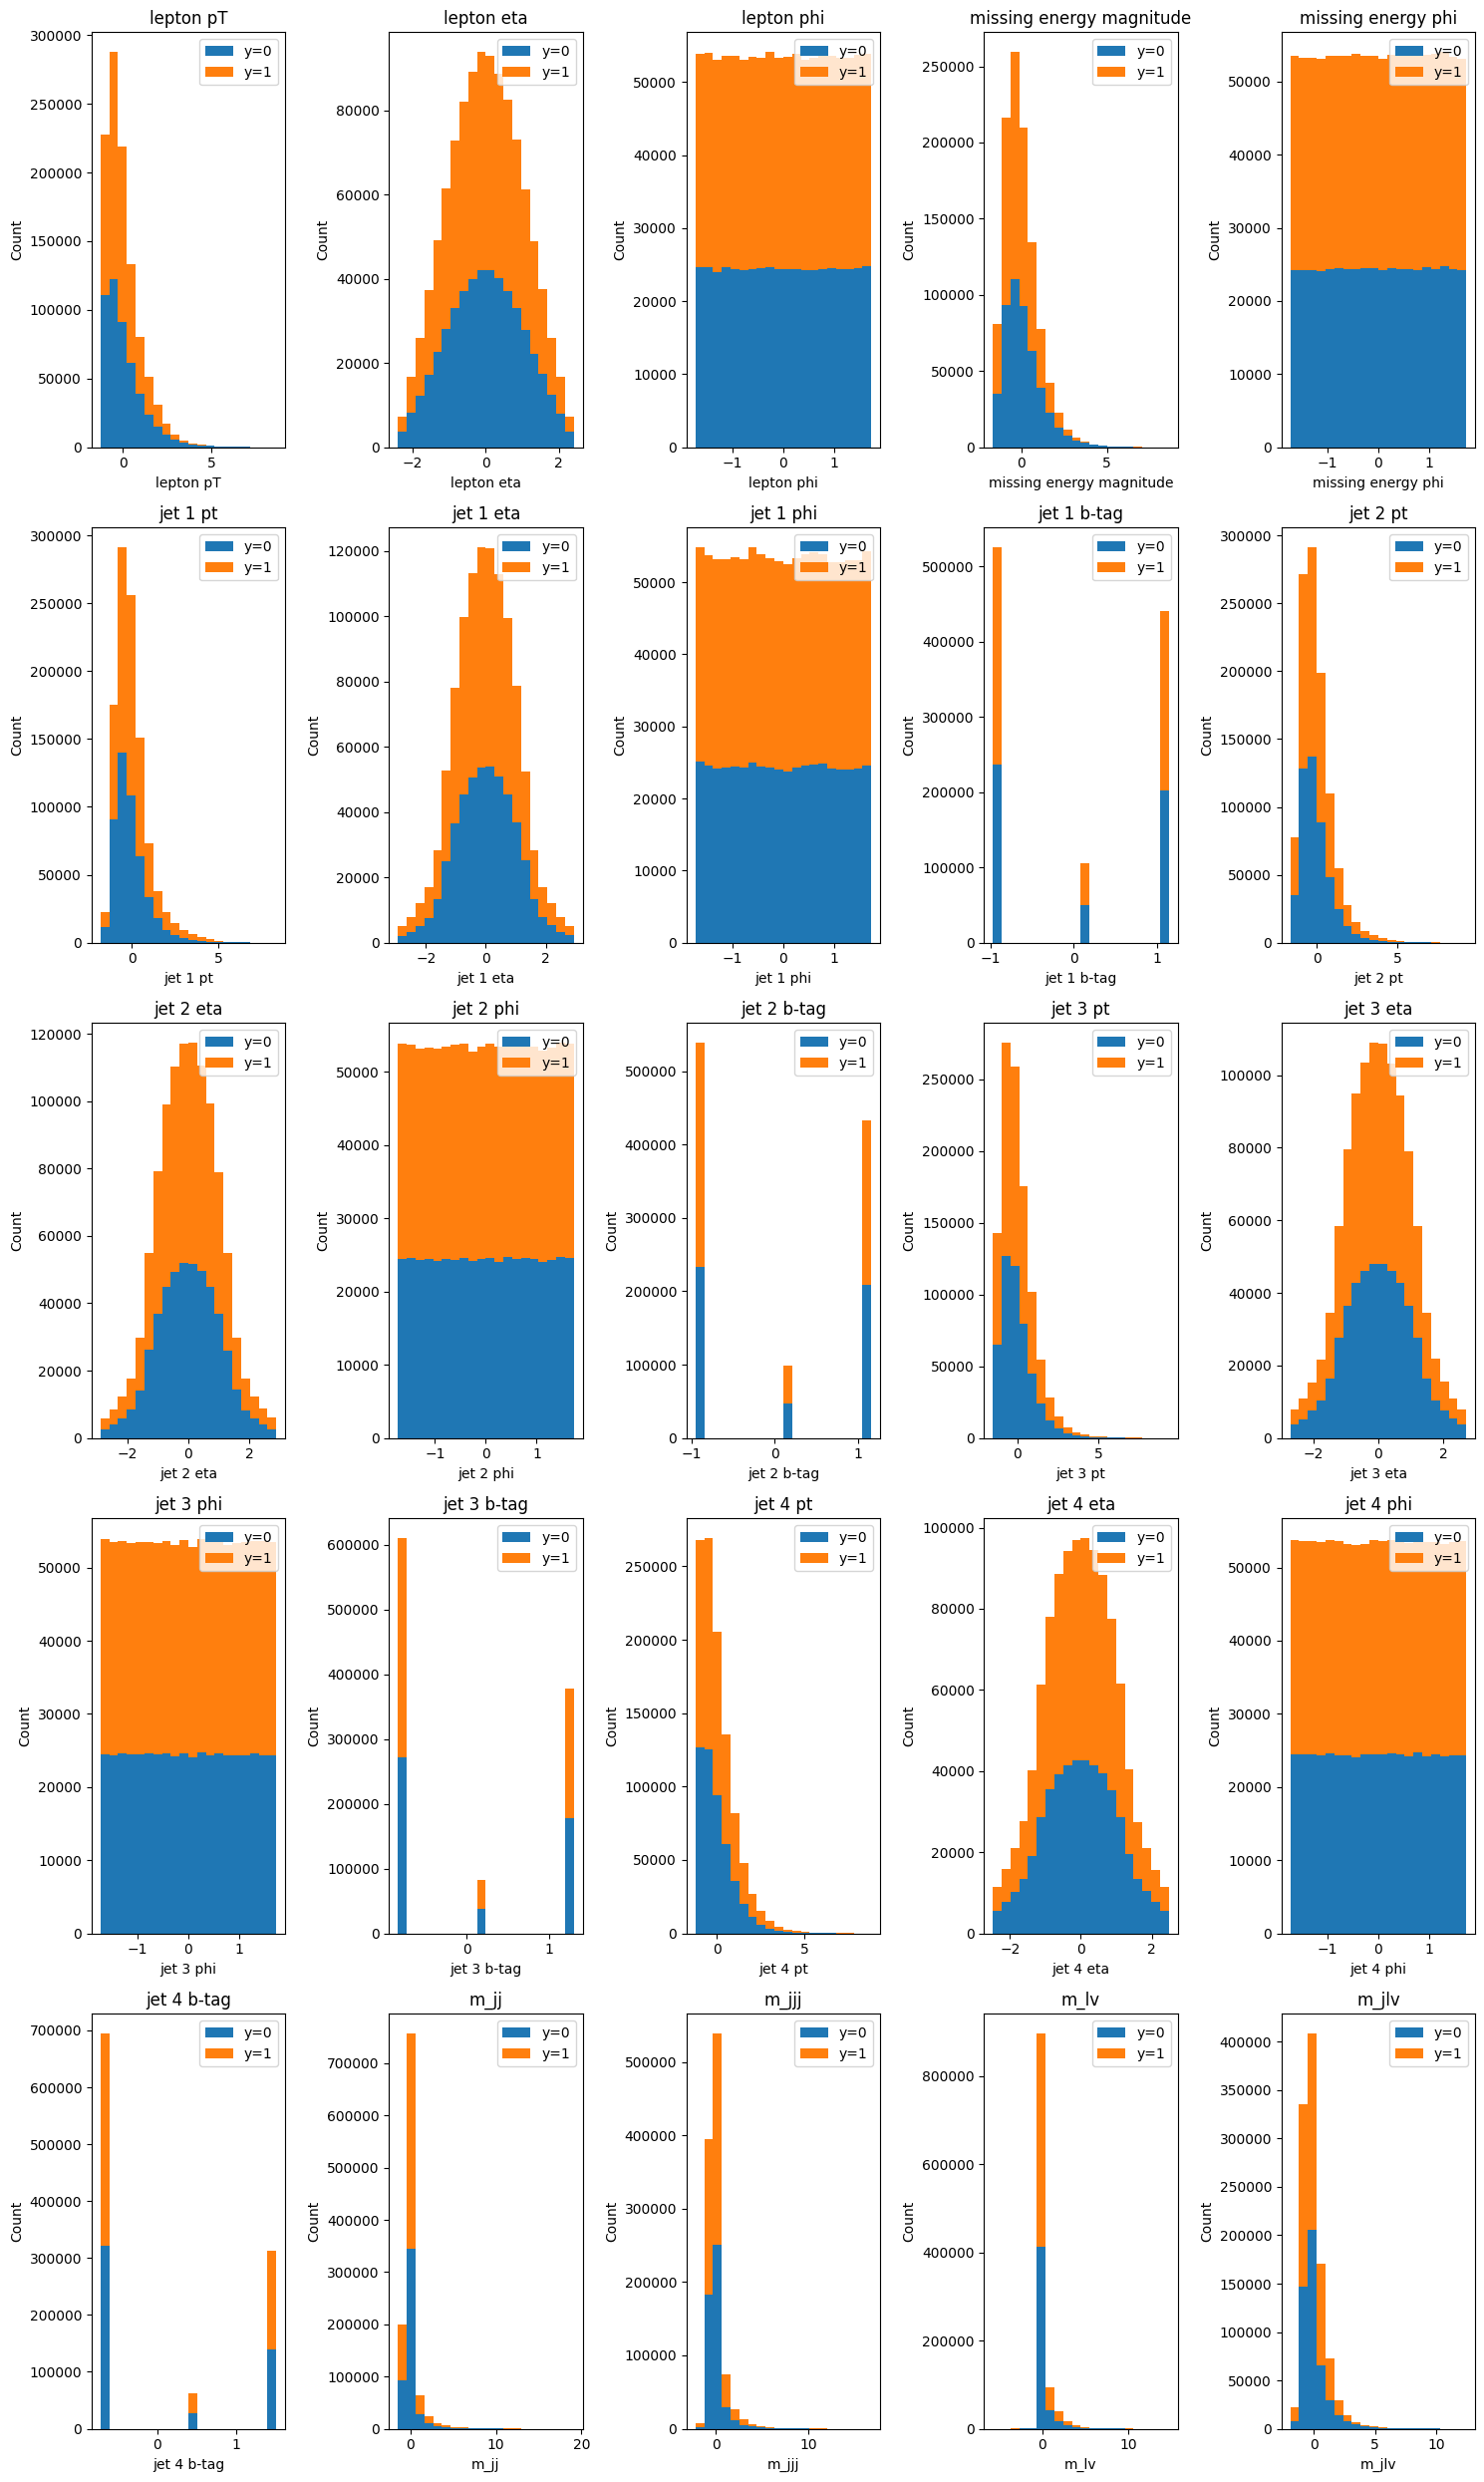

In [24]:
SAMPLE_FRACTION = 0.1 # Amount of data to use in the plots.
PLOTS_PER_ROW = 5

AMOUNT_OF_FEATURES = len(normalized_df.columns) - 1

NUMBER_OF_ROWS = AMOUNT_OF_FEATURES // PLOTS_PER_ROW + (AMOUNT_OF_FEATURES % PLOTS_PER_ROW > 0)

plt.figure(figsize=(15, PLOTS_PER_ROW * NUMBER_OF_ROWS))

features = [column for column in normalized_df.columns if column != Feature.TARGET.value]

for position, feature in enumerate(features):
    plt.subplot(NUMBER_OF_ROWS, PLOTS_PER_ROW, position + 1)

    # Get a sample of the data, to reduce the computing resources required.
    sample_df = normalized_df.sample(frac=SAMPLE_FRACTION)
    x = sample_df[feature]
    y = sample_df[Feature.TARGET.value]

    # Create two histograms and stack them.
    plt.hist([x[y == 0], x[y == 1]], bins=20, stacked=True, label=['y=0', 'y=1'])
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()

Upon inspection, manual scaling is performed on some attributes, in order to re-scale then.

In [25]:
scaled_df = normalized_df.drop(Feature.TARGET.value, axis=1)
scaled_df[Feature.TARGET.value] = normalized_df[Feature.TARGET.value]
scaled_df[Feature.LEPTON_PT.value] = np.sqrt(np.sqrt(scaled_df[Feature.LEPTON_PT.value]))
scaled_df[Feature.MISSING_ENERGY_MAG.value] = np.sqrt(np.sqrt(scaled_df[Feature.MISSING_ENERGY_MAG.value]))
scaled_df[Feature.JET_1_PT.value] = np.sqrt(np.sqrt(scaled_df[Feature.JET_1_PT.value]))
scaled_df[Feature.JET_2_PT.value] = np.sqrt(np.sqrt(scaled_df[Feature.JET_2_PT.value]))
scaled_df[Feature.JET_3_PT.value] = np.sqrt(np.sqrt(scaled_df[Feature.JET_3_PT.value]))
scaled_df[Feature.JET_4_PT.value] = np.sqrt(np.sqrt(scaled_df[Feature.JET_4_PT.value]))
scaled_df[Feature.M_JJ.value] = np.sqrt(np.sqrt(np.sqrt(scaled_df[Feature.M_JJ.value])))
scaled_df[Feature.M_JJJ.value] = np.sqrt(np.sqrt(np.sqrt(scaled_df[Feature.M_JJJ.value])))
scaled_df[Feature.M_LV.value] = np.sqrt(np.sqrt(scaled_df[Feature.M_LV.value]))
scaled_df[Feature.M_JLV.value] = np.sqrt(np.sqrt(scaled_df[Feature.M_JLV.value]))

/Users/martincastro/Library/Python/3.8/lib/python/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Plotting data again, in order to verify that the skewed data has been shifted to the center.

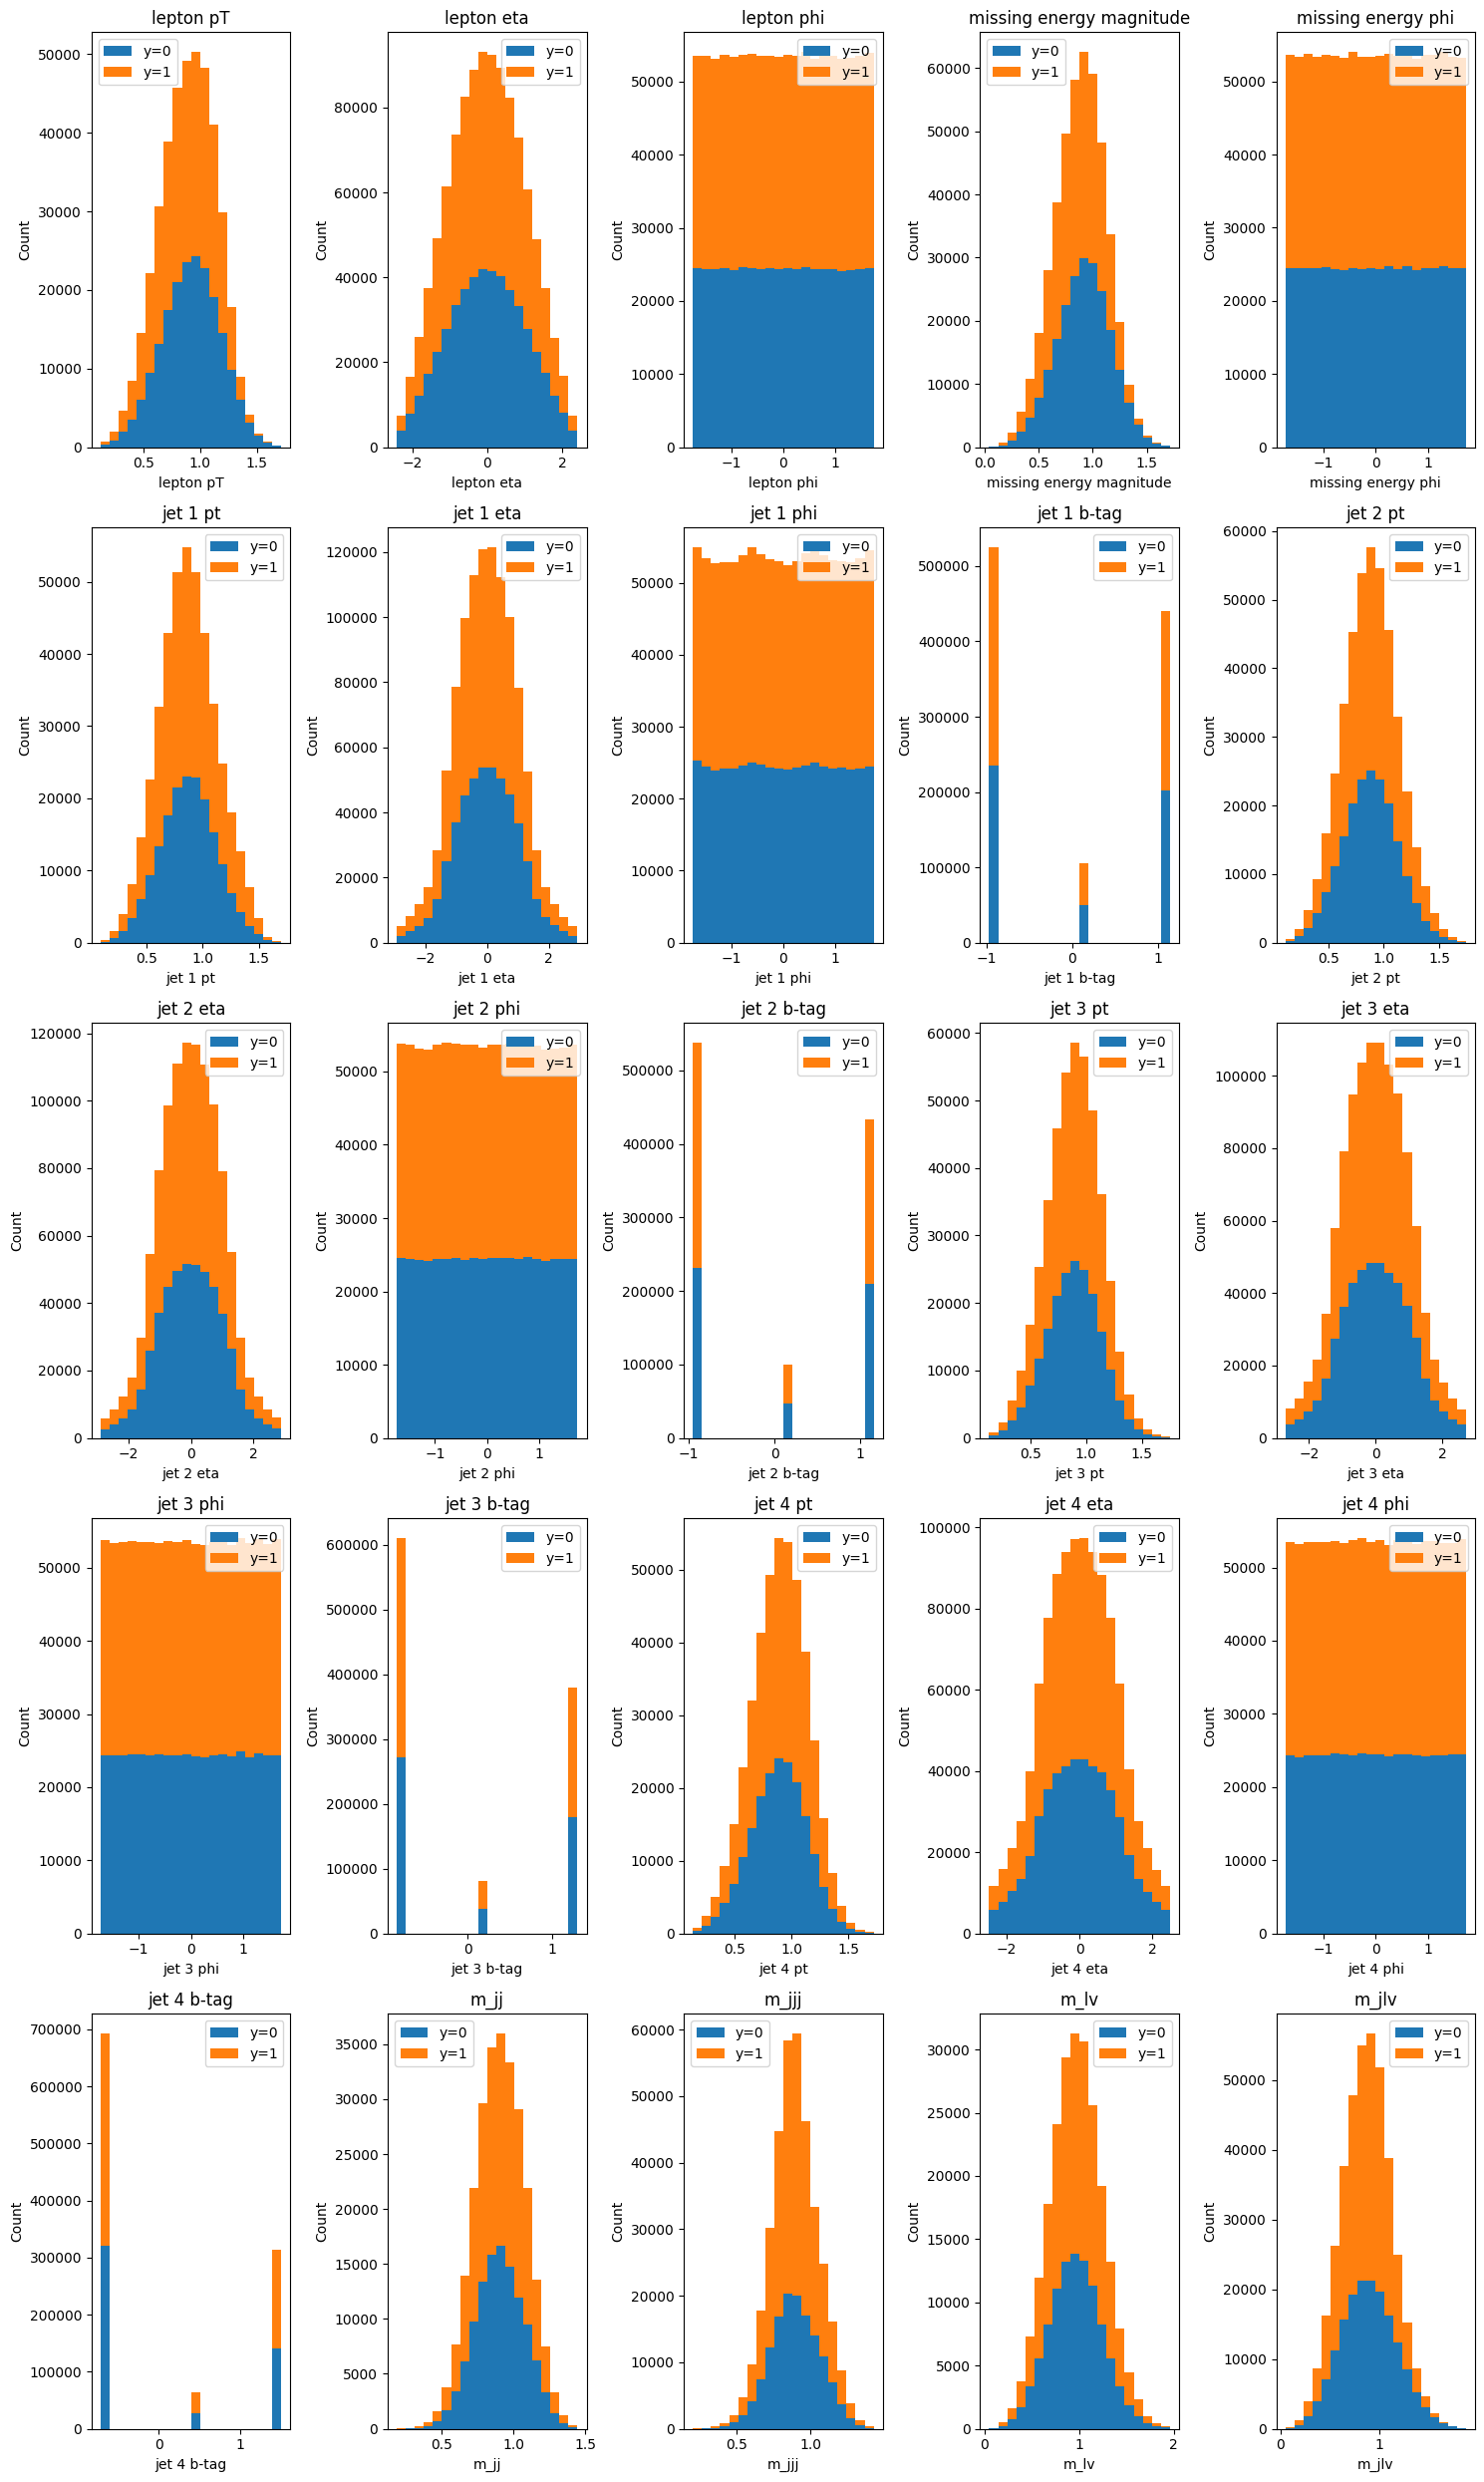

In [26]:
SAMPLE_FRACTION = 0.1 # Amount of data to use in the plots.
PLOTS_PER_ROW = 5

AMOUNT_OF_FEATURES = len(normalized_df.columns) - 1

NUMBER_OF_ROWS = AMOUNT_OF_FEATURES // PLOTS_PER_ROW + (AMOUNT_OF_FEATURES % PLOTS_PER_ROW > 0)

plt.figure(figsize=(15, PLOTS_PER_ROW * NUMBER_OF_ROWS))

features = [column for column in normalized_df.columns if column != Feature.TARGET.value]

for position, feature in enumerate(features):
    plt.subplot(NUMBER_OF_ROWS, PLOTS_PER_ROW, position + 1)

    # Get a sample of the data, to reduce the computing resources required.
    sample_df = scaled_df.sample(frac=SAMPLE_FRACTION)
    x = sample_df[feature]
    y = scaled_df[Feature.TARGET.value]

    # Create two histograms and stack them.
    plt.hist([x[y == 0], x[y == 1]], bins=20, stacked=True, label=['y=0', 'y=1'])
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()

Plotting deciles for each feature.

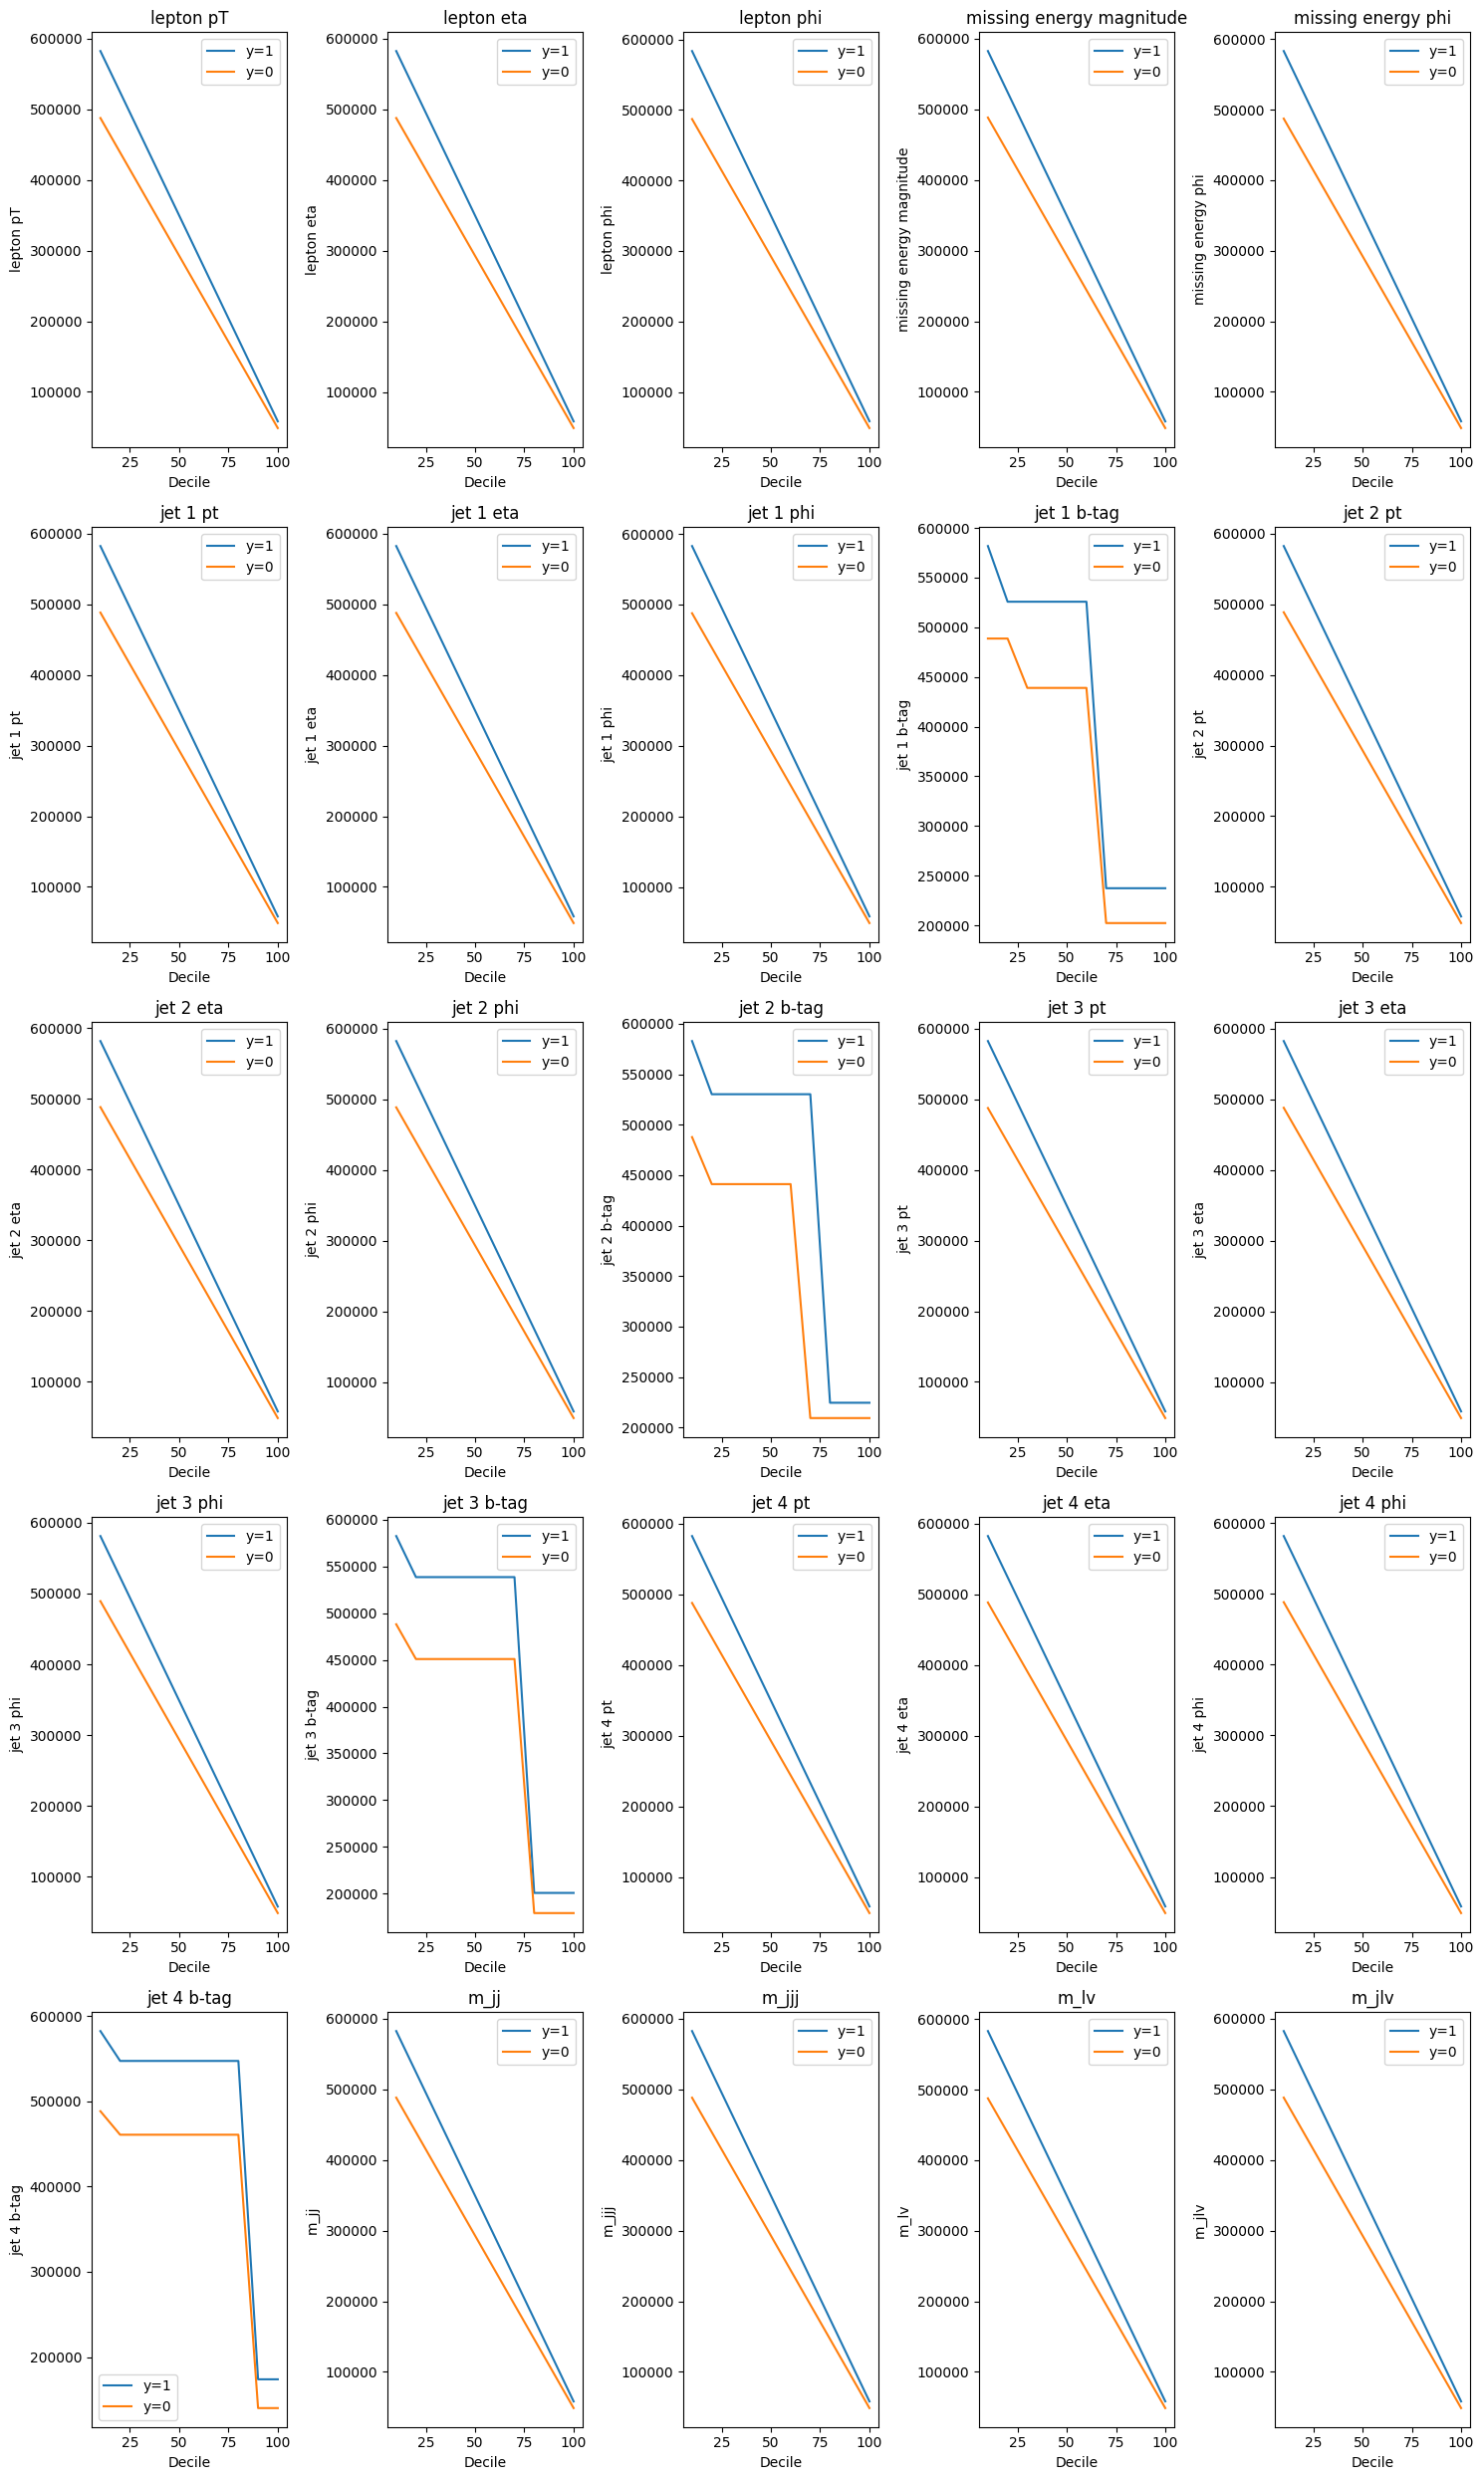

In [27]:
SAMPLE_FRACTION = 0.1 # Amount of data to use in the plots.
PLOTS_PER_ROW = 5

AMOUNT_OF_FEATURES = len(normalized_df.columns) - 1

NUMBER_OF_ROWS = AMOUNT_OF_FEATURES // PLOTS_PER_ROW + (AMOUNT_OF_FEATURES % PLOTS_PER_ROW > 0)

plt.figure(figsize=(15, PLOTS_PER_ROW * NUMBER_OF_ROWS))

features = [column for column in normalized_df.columns if column != Feature.TARGET.value]

for position, feature in enumerate(features):
    plt.subplot(NUMBER_OF_ROWS, PLOTS_PER_ROW, position + 1)

    # Get a sample of the data, to reduce the computing resources required.
    sample_df = normalized_df.sample(frac=SAMPLE_FRACTION).abs()
    x = sample_df[feature]
    y = sample_df[Feature.TARGET.value]

    # Split the data into positive and negative signals.
    deciles = np.arange(10, 110, 10)
    positive_counts = [np.sum((x[y == 1] >= np.percentile(x[y == 1], decile - 10))) for decile in deciles]
    negative_counts = [np.sum((x[y == 0] >= np.percentile(x[y == 0], decile - 10))) for decile in deciles]

    # Create two line plots for positive and negative signals
    plt.plot(deciles, positive_counts, label='y=1')
    plt.plot(deciles, negative_counts, label='y=0')
    plt.title(feature)
    plt.xlabel('Decile')
    plt.ylabel(feature)
    plt.legend()

plt.tight_layout()
plt.show()

# 4. Machine Learning

### 4.1 Dataset Spliting

Split the datasets into training, evaluation and test sets. Straified sampling is used.

In [28]:
SPLIT_RATE = 0.3 # Percentage of data used for testing the model.

X_train, X_temp, y_train, y_temp = train_test_split(
    normalized_df.drop(Feature.TARGET.value, axis=1),
    normalized_df[Feature.TARGET.value], 
    test_size=SPLIT_RATE,
    random_state=53,
    stratify=normalized_df[Feature.TARGET.value]
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp, 
    test_size=0.5,
    random_state=53,
    stratify=y_temp
)

print('Dataset:', scaled_df.shape)
print('Training:', X_train.shape, y_train.shape)
print('Evaluation:', X_val.shape, y_val.shape)
print('Testing:', X_test.shape, y_test.shape)

assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == scaled_df.shape[0]
assert X_train.shape[1] + + 1 == scaled_df.shape[1]
assert X_val.shape[1] + + 1 == scaled_df.shape[1]
assert X_test.shape[1] + + 1 == scaled_df.shape[1]
assert X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == y_train.shape[0] + y_val.shape[0] + y_test.shape[0]

Dataset: (10704979, 26)
Training: (7493485, 25) (7493485,)
Evaluation: (1605747, 25) (1605747,)
Testing: (1605747, 25) (1605747,)


### 4.2 Model Architecture

Define the architecture and train the Neural Network using the training and evaluation datasets.

In [29]:
model = Sequential([
    Dense(300, input_dim=scaled_df.shape[1] - 1, activation='relu', kernel_initializer=he_normal(seed=10)),

    # Fully-connected hidden layers, with Dropout, to avoid overfitting.
    Dense(300, activation='relu', kernel_initializer=he_normal(seed=110)), Dropout(0.005),
    Dense(300, activation='relu', kernel_initializer=he_normal(seed=120)), Dropout(0.005),
    Dense(300, activation='relu', kernel_initializer=he_normal(seed=130)), Dropout(0.005),
    Dense(300, activation='relu', kernel_initializer=he_normal(seed=130)), Dropout(0.005),
    Dense(300, activation='relu', kernel_initializer=he_normal(seed=160)), Dropout(0.005),
    Dense(300, activation='relu', kernel_initializer=he_normal(seed=170)), Dropout(0.005),

    # Output layer, with sigmoid activation function, to throw results from 0 to 1.
    Dense(1, activation='sigmoid', kernel_initializer=he_normal(seed=14))
])
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        keras.metrics.Precision(),
        keras.metrics.Recall()
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               7800      
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 300)               90300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_3 (Dense)             (None, 300)               90300     
                                                                 
 dropout_2 (Dropout)         (None, 300)               0

### 4.3 Model Training

Running GridSearch, to find the best combination of batch size and epochs.

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Stop after 3 epochs without improvement.
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=128,
    callbacks=[early_stopping],
)

Epoch 1/25
58543/58543 [==============================] - 381s 6ms/step - loss: 0.5525 - accuracy: 0.7133 - precision: 0.7164 - recall: 0.7830 - val_loss: 0.5290 - val_accuracy: 0.7308 - val_precision: 0.7384 - val_recall: 0.7821
Epoch 2/25
58543/58543 [==============================] - 344s 6ms/step - loss: 0.5172 - accuracy: 0.7401 - precision: 0.7431 - recall: 0.7983 - val_loss: 0.5076 - val_accuracy: 0.7465 - val_precision: 0.7592 - val_recall: 0.7820
Epoch 3/25
58543/58543 [==============================] - 401s 7ms/step - loss: 0.5015 - accuracy: 0.7512 - precision: 0.7541 - recall: 0.8053 - val_loss: 0.4962 - val_accuracy: 0.7547 - val_precision: 0.7534 - val_recall: 0.8160
Epoch 4/25
58543/58543 [==============================] - 414s 7ms/step - loss: 0.4944 - accuracy: 0.7565 - precision: 0.7604 - recall: 0.8063 - val_loss: 0.4937 - val_accuracy: 0.7564 - val_precision: 0.7636 - val_recall: 0.7997
Epoch 5/25
58543/58543 [==============================] - 399s 7ms/step - loss: 

### 4.4 Saving Model

Save the Keras model so that it can be used by the API server.

In [31]:
model.save('viu_model.h5')

/Users/martincastro/Library/Python/3.8/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Save the dataframe containing the statistics of the dataset. This will be used to normalize real-time predictions.

In [32]:
stats_df.to_csv('viu_stats.csv', index=True)

# 5. Evaluation

### 5.1 Biased Evaluation

Plot the evolution of training and validation accuracy across multiple epochs.

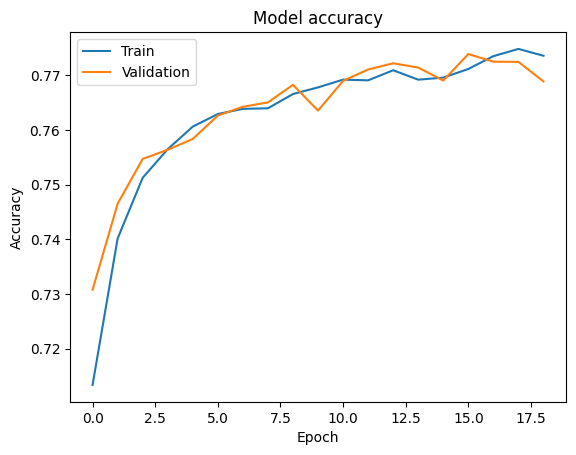

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### 5.2 Unbiased Evaluation

Calculate the accuracy against the test set, which was never shared with the model until now.

In [34]:
loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
print(f"Validation Recall: {recall}")
print(f"Validation Precision: {precision}")

50180/50180 [==============================] - 67s 1ms/step - loss: 0.4756 - accuracy: 0.7698 - precision: 0.7689 - recall: 0.8246
Validation Loss: 0.47564175724983215
Validation Accuracy: 0.7697526216506958
Validation Recall: 0.8245527148246765
Validation Precision: 0.768875002861023


### 5.3 Test Prediction

Test the model with a real prediction.

In [35]:
y_hat = model.predict(X_test)
y_hat[:3]

50180/50180 [==============================] - 55s 1ms/step


array([[0.32648927],
       [0.63075197],
       [0.87651336]], dtype=float32)

### 5.4 Confusion Matrix

Plot the confusion matrix, to visualize false positives and false negatives.

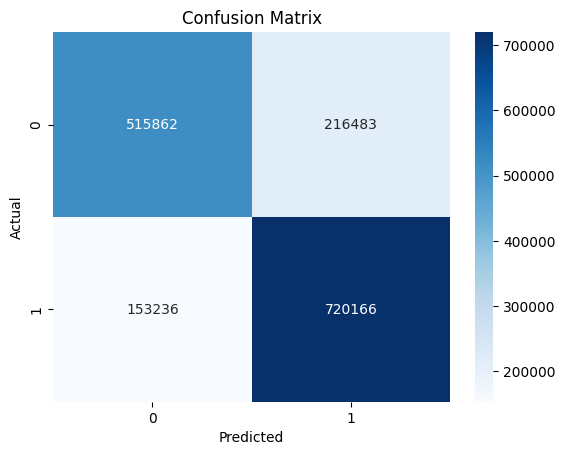

In [36]:
cm = confusion_matrix(y_test, y_hat > 0.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Plot the confusion matrix with a very low threshold that increases precision to 97%

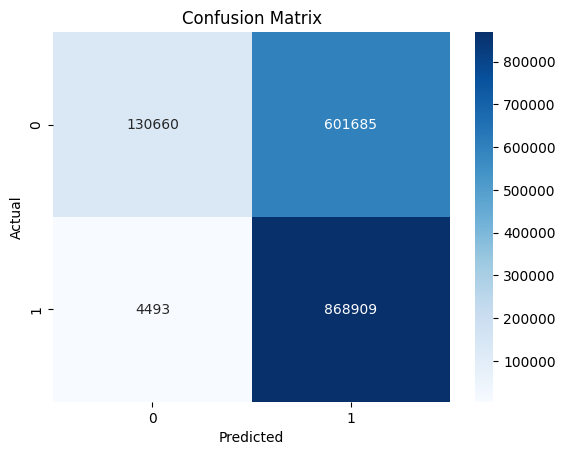

In [37]:
cm = confusion_matrix(y_test, y_hat > 0.05)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()